In [10]:
import json
import matplotlib.pyplot as plt
import numpy as np
import torch
from physvae import utils
from physvae.galaxy.model import VAE

In [11]:
# setting
datadir = './data/galaxy'
dataname = 'test'
modeldir = './out_galaxy_nnonly/'

In [12]:
# load test data
data_all = np.load('{}/data_all.npy'.format(datadir))
idx_test = np.loadtxt('{}/idx_{}.txt'.format(modeldir, dataname)).astype(np.intp)
data_test = data_all[idx_test]

In [13]:
device = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")

# set and load model (aux only)
with open('{}/args.json'.format(modeldir), 'r') as f:
    args_tr_dict = json.load(f)
model = VAE(args_tr_dict).to(device)
model.load_state_dict(torch.load('{}/model.pt'.format(modeldir), map_location=device))
model.eval()
print("model loaded")

model loaded


In [14]:
# inference & reconstruction on test data
data_tensor = torch.Tensor(data_test).to(device).view(-1,3,69,69)
with torch.no_grad():
    # aux only
    z_phy_stat, z_aux2_stat, unmixed = model.encode(data_tensor)
    z_phy, z_aux2 = model.draw(z_phy_stat, z_aux2_stat, hard_z=False)
    x_full, _, _, _ = model.decode(z_phy, z_aux2, full=True)

In [15]:
# random generation
torch.manual_seed(123456789)
n=100
with torch.no_grad():
    # phy and aux
    rand_z_aux2 = torch.randn(n, model.dim_z_aux2)*10.0
    rand_I0 = torch.rand(n,1)*0.25+0.5
    rand_A = torch.rand(n,1)*0.25+0.35
    rand_e = torch.rand(n,1)*0.15+0.7
    rand_theta = torch.rand(n,1)*2.3+0.5
    rand_z_phy = torch.cat([rand_I0, rand_A, rand_e, rand_theta], dim=1)
    rand_x_full, _, _, _ = model.decode(rand_z_phy, rand_z_aux2, full=True)

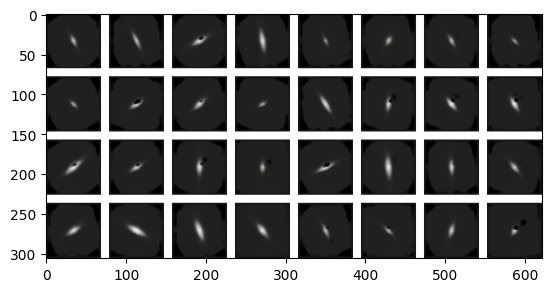

In [16]:
# show / save
H=4; W=8
k=10 # margin [px]

# phy and aux
bigimage = torch.empty(0, 69*W+k*(W-1), 3)
c=0
for i in range(H):
    tmp = torch.empty(69,0,3)
    for j in range(W):
        tmp = torch.cat([tmp, rand_x_full[c].cpu().permute(1,2,0)], dim=1); c+=1
        if j<W-1:
            tmp = torch.cat([tmp, torch.ones(69,k,3)], dim=1)
    bigimage = torch.cat([bigimage, tmp.clone()], dim=0)
    if i<H-1:
        bigimage = torch.cat([bigimage, torch.ones(k, 69*W+k*(W-1), 3)], dim=0)

plt.imshow(bigimage); plt.show()
# plt.imsave('galaxy_randgen.png', bigimage.numpy())